# HDB Resale Price Prediction

## Machine Learning Modelling

### Import Libraries

In [2]:
# General
import math
import random
random.seed(42)
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import randint
from scipy.stats import uniform

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn import tree

# Pre-Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler      # Remove Mean and scale to Unit Variance
from sklearn.preprocessing import PowerTransformer    # Log Transformation
from sklearn.preprocessing import OneHotEncoder

# Feature Engineering
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Evaluation Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
import catboost as cb

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Warnings
import warnings
warnings.filterwarnings('ignore')

### Import Dataset

In [3]:
# Importing Data
data_hdb_cleaned = pd.read_csv('../dataset/hdb_last15_cleaned.csv')
data_hdb_cleaned.index += 1
data_hdb_cleaned

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,...,recreational_within_1km_average_rating,recreational_within_2km_count,recreational_within_2km_average_rating,education_within_1km_count,education_within_1km_average_rating,education_within_2km_count,education_within_2km_average_rating,postal_code,region,price_per_sqm
1,SEMBAWANG,5 ROOM,Premium Apartment,111.0,362000.0,2009-07-01,2001,01 TO 05,357A,91.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3261.261261
2,SEMBAWANG,5 ROOM,Premium Apartment,110.0,370000.0,2009-08-01,2001,06 TO 10,357A,91.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3363.636364
3,SEMBAWANG,5 ROOM,Premium Apartment,110.0,403000.0,2010-01-01,2001,16 TO 20,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3663.636364
4,SEMBAWANG,4 ROOM,Premium Apartment,95.0,350000.0,2010-07-01,2001,01 TO 05,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,3684.210526
5,SEMBAWANG,4 ROOM,Premium Apartment,95.0,399000.0,2010-07-01,2001,10 TO 15,357A,90.000000,...,3.733333,6.0,3.916667,4.0,4.275,8.0,4.250,751357.0,North,4200.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316854,BUKIT MERAH,5 ROOM,Improved,114.0,921000.0,2022-10-01,1974,10 TO 15,87,50.750000,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8078.947368
316855,BUKIT MERAH,5 ROOM,Improved,117.0,930000.0,2022-10-01,1974,01 TO 05,87,50.750000,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,7948.717949
316856,BUKIT MERAH,5 ROOM,Improved,117.0,978000.0,2022-12-01,1974,10 TO 15,87,50.666667,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8358.974359
316857,BUKIT MERAH,5 ROOM,Improved,114.0,950000.0,2022-12-01,1974,21 TO 25,87,50.583333,...,4.057143,78.0,4.052564,3.0,2.700,25.0,3.348,160087.0,South,8333.333333


In [4]:
# Understanding Data I
data_hdb_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316858 entries, 1 to 316858
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   town                                    316858 non-null  object 
 1   flat_type                               316858 non-null  object 
 2   flat_model                              316858 non-null  object 
 3   floor_area_sqm                          316858 non-null  float64
 4   resale_price                            316858 non-null  float64
 5   month                                   316858 non-null  object 
 6   lease_commence_date                     316858 non-null  int64  
 7   storey_range                            316858 non-null  object 
 8   block                                   316858 non-null  object 
 9   remaining_lease                         316858 non-null  float64
 10  address                                 3168

In [5]:
# Understanding Data II
data_hdb_cleaned.describe()

,floor_area_sqm,resale_price,lease_commence_date,remaining_lease,lat,long,nearest_distance_to_mrt,avg_long,avg_lat,healthcare_within_1km_count,...,recreational_within_1km_count,recreational_within_1km_average_rating,recreational_within_2km_count,recreational_within_2km_average_rating,education_within_1km_count,education_within_1km_average_rating,education_within_2km_count,education_within_2km_average_rating,postal_code,price_per_sqm
count,316858.000000,3.168580e+05,316858.00000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,...,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316858.000000,316410.000000,316858.000000
mean,97.479359,4.412566e+05,1991.72968,75.267866,1.365842,103.838676,0.624044,103.838680,1.365844,5.988376,...,3.837429,3.928042,11.887855,4.055404,4.855336,4.037460,14.403837,4.095730,551205.063677,4581.617630
std,24.742062,1.467689e+05,11.84791,11.684112,0.042881,0.072799,0.378055,0.072687,0.042815,5.242842,...,3.054143,0.688451,8.638953,0.134527,2.244488,0.574591,4.698377,0.183904,186035.992530,1181.663412
min,31.000000,1.270000e+05,1966.00000,43.000000,1.270380,103.644248,0.023000,103.688247,1.272255,0.000000,...,0.000000,0.000000,2.000000,3.577778,0.000000,0.000000,2.000000,2.786667,50004.000000,1445.920000
25%,74.000000,3.360000e+05,1984.00000,66.000000,1.336264,103.774173,0.337000,103.774336,1.336320,3.000000,...,2.000000,3.933333,8.000000,3.983333,3.000000,3.975000,12.000000,3.994737,470709.000000,3798.076923
50%,97.000000,4.150000e+05,1989.00000,75.000000,1.362565,103.844027,0.552000,103.844611,1.362350,5.000000,...,3.000000,4.050000,10.000000,4.075000,5.000000,4.133333,14.000000,4.130000,560323.000000,4368.932039
75%,113.000000,5.150000e+05,2000.00000,85.000000,1.392710,103.898351,0.828000,103.898503,1.391577,8.000000,...,5.000000,4.150000,13.000000,4.136364,6.000000,4.266667,17.000000,4.205263,680518.000000,5074.626866
max,280.000000,1.418000e+06,2018.00000,94.916667,1.457071,103.964915,2.154000,103.962400,1.455540,61.000000,...,41.000000,4.700000,105.000000,4.380000,19.000000,5.000000,37.000000,4.500000,825195.000000,14731.182796


### Split Training & Testing Dataset

In [6]:
# Dependent Variable
target_list = ['resale_price']

# Independent Variables
feature_list = ['flat_type', 'floor_area_sqm', 'month', 'lease_commence_date', 'storey_range', 'remaining_lease',
                'nearest_distance_to_mrt', 'healthcare_within_1km_count', 'healthcare_within_1km_average_rating', 
                'healthcare_within_2km_count', 'healthcare_within_2km_average_rating', 'recreational_within_1km_count', 
                'recreational_within_1km_average_rating', 'recreational_within_2km_count', 'recreational_within_2km_average_rating', 
                'education_within_1km_count', 'education_within_1km_average_rating', 'education_within_2km_count',
                'education_within_2km_average_rating', 'region', 'price_per_sqm']

print(feature_list)

# Selecting Target Variable and Features from Dataset
X = data_hdb_cleaned[feature_list]
y = data_hdb_cleaned[target_list]

['flat_type', 'floor_area_sqm', 'month', 'lease_commence_date', 'storey_range', 'remaining_lease', 'nearest_distance_to_mrt', 'healthcare_within_1km_count', 'healthcare_within_1km_average_rating', 'healthcare_within_2km_count', 'healthcare_within_2km_average_rating', 'recreational_within_1km_count', 'recreational_within_1km_average_rating', 'recreational_within_2km_count', 'recreational_within_2km_average_rating', 'education_within_1km_count', 'education_within_1km_average_rating', 'education_within_2km_count', 'education_within_2km_average_rating', 'region', 'price_per_sqm']


In [7]:
# Split Training & Testing Dataset (80:20 Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(253486, 21) (63372, 21) (253486, 1) (63372, 1)


In [8]:
# Reset Indexes
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Data Preprocessing

#### Data Cleaning

In [9]:
# Check Missing Data
X_train.isnull().sum()[X_train.isnull().sum() > 0]
X_test.isnull().sum()[X_test.isnull().sum() > 0]

Series([], dtype: int64)

In [10]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 21 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   flat_type                               253486 non-null  object 
 1   floor_area_sqm                          253486 non-null  float64
 2   month                                   253486 non-null  object 
 3   lease_commence_date                     253486 non-null  int64  
 4   storey_range                            253486 non-null  object 
 5   remaining_lease                         253486 non-null  float64
 6   nearest_distance_to_mrt                 253486 non-null  float64
 7   healthcare_within_1km_count             253486 non-null  float64
 8   healthcare_within_1km_average_rating    253486 non-null  float64
 9   healthcare_within_2km_count             253486 non-null  float64
 10  healthcare_within_2km_average_rating    2534

Upon visual inspection of the dataset, the month column more accurate represents the date sold. The datetime data type would be more appropriate.

In [11]:
# Rename month column to better reflect data
X_train = X_train.rename(columns={'month': 'date_sold'})
X_test = X_test.rename(columns={'month': 'date_sold'})

# Change data type
X_train['date_sold'] = pd.to_datetime(X_train['date_sold'])
X_train['flat_type'] = X_train['flat_type'].astype('category')
X_train['region'] = X_train['region'].astype('category')

X_test['date_sold'] = pd.to_datetime(X_test['date_sold'])
X_test['flat_type'] = X_test['flat_type'].astype('category')
X_test['region'] = X_test['region'].astype('category')

#### Data Transformation

In [12]:
# DT Methods i.e. StandardScaler, PowerTransformer



### Feature Engineering

#### Encoding

In [13]:
# Perform one-hot encoding for the 'flat_type', 'storey_range', and 'region' columns
X_train_one_hot_flat_type = pd.get_dummies(X_train['flat_type'], prefix='flat_type')
X_train_one_hot_storey_range = pd.get_dummies(X_train['storey_range'], prefix='storey_range')
X_train_one_hot_region = pd.get_dummies(X_train['region'], prefix='region')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_train_encoded = pd.concat([X_train, X_train_one_hot_flat_type, X_train_one_hot_storey_range, X_train_one_hot_region], axis=1)

# Drop the original categorical columns if you no longer need them
X_train_encoded = X_train_encoded.drop(columns=['flat_type', 'storey_range', 'region'])

X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   floor_area_sqm                          253486 non-null  float64       
 1   date_sold                               253486 non-null  datetime64[ns]
 2   lease_commence_date                     253486 non-null  int64         
 3   remaining_lease                         253486 non-null  float64       
 4   nearest_distance_to_mrt                 253486 non-null  float64       
 5   healthcare_within_1km_count             253486 non-null  float64       
 6   healthcare_within_1km_average_rating    253486 non-null  float64       
 7   healthcare_within_2km_count             253486 non-null  float64       
 8   healthcare_within_2km_average_rating    253486 non-null  float64       
 9   recreational_within_1km_count        

In [14]:
# Perform one-hot encoding for the 'flat_type', 'storey_range', and 'region' columns
X_test_one_hot_flat_type = pd.get_dummies(X_test['flat_type'], prefix='flat_type')
X_test_one_hot_storey_range = pd.get_dummies(X_test['storey_range'], prefix='storey_range')
X_test_one_hot_region = pd.get_dummies(X_test['region'], prefix='region')

# Concatenate the one-hot encoded DataFrames with the original DataFrame
X_test_encoded = pd.concat([X_test, X_test_one_hot_flat_type, X_test_one_hot_storey_range, X_test_one_hot_region], axis=1)

# Drop the original categorical columns if you no longer need them
X_test_encoded = X_test_encoded.drop(columns=['flat_type', 'storey_range', 'region'])

X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63372 entries, 0 to 63371
Data columns (total 40 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   floor_area_sqm                          63372 non-null  float64       
 1   date_sold                               63372 non-null  datetime64[ns]
 2   lease_commence_date                     63372 non-null  int64         
 3   remaining_lease                         63372 non-null  float64       
 4   nearest_distance_to_mrt                 63372 non-null  float64       
 5   healthcare_within_1km_count             63372 non-null  float64       
 6   healthcare_within_1km_average_rating    63372 non-null  float64       
 7   healthcare_within_2km_count             63372 non-null  float64       
 8   healthcare_within_2km_average_rating    63372 non-null  float64       
 9   recreational_within_1km_count           63372 non-

### Feature Extraction 

In [15]:
# Principal Component Analysis

# Exclude datetime as PCA only accepts numeric
X_train_numeric = X_train_encoded.drop(columns=['date_sold'])
X_test_numeric = X_test_encoded.drop(columns=['date_sold'])

# Initialise PCA with 10 components
pca = PCA(n_components=10)
pca.fit(X_train_numeric)

X_train_pca = pca.transform(X_train_numeric)

print("Shape of Transformed Data", X_train_pca.shape)

Shape of Transformed Data (253486, 10)


### Feature Selection

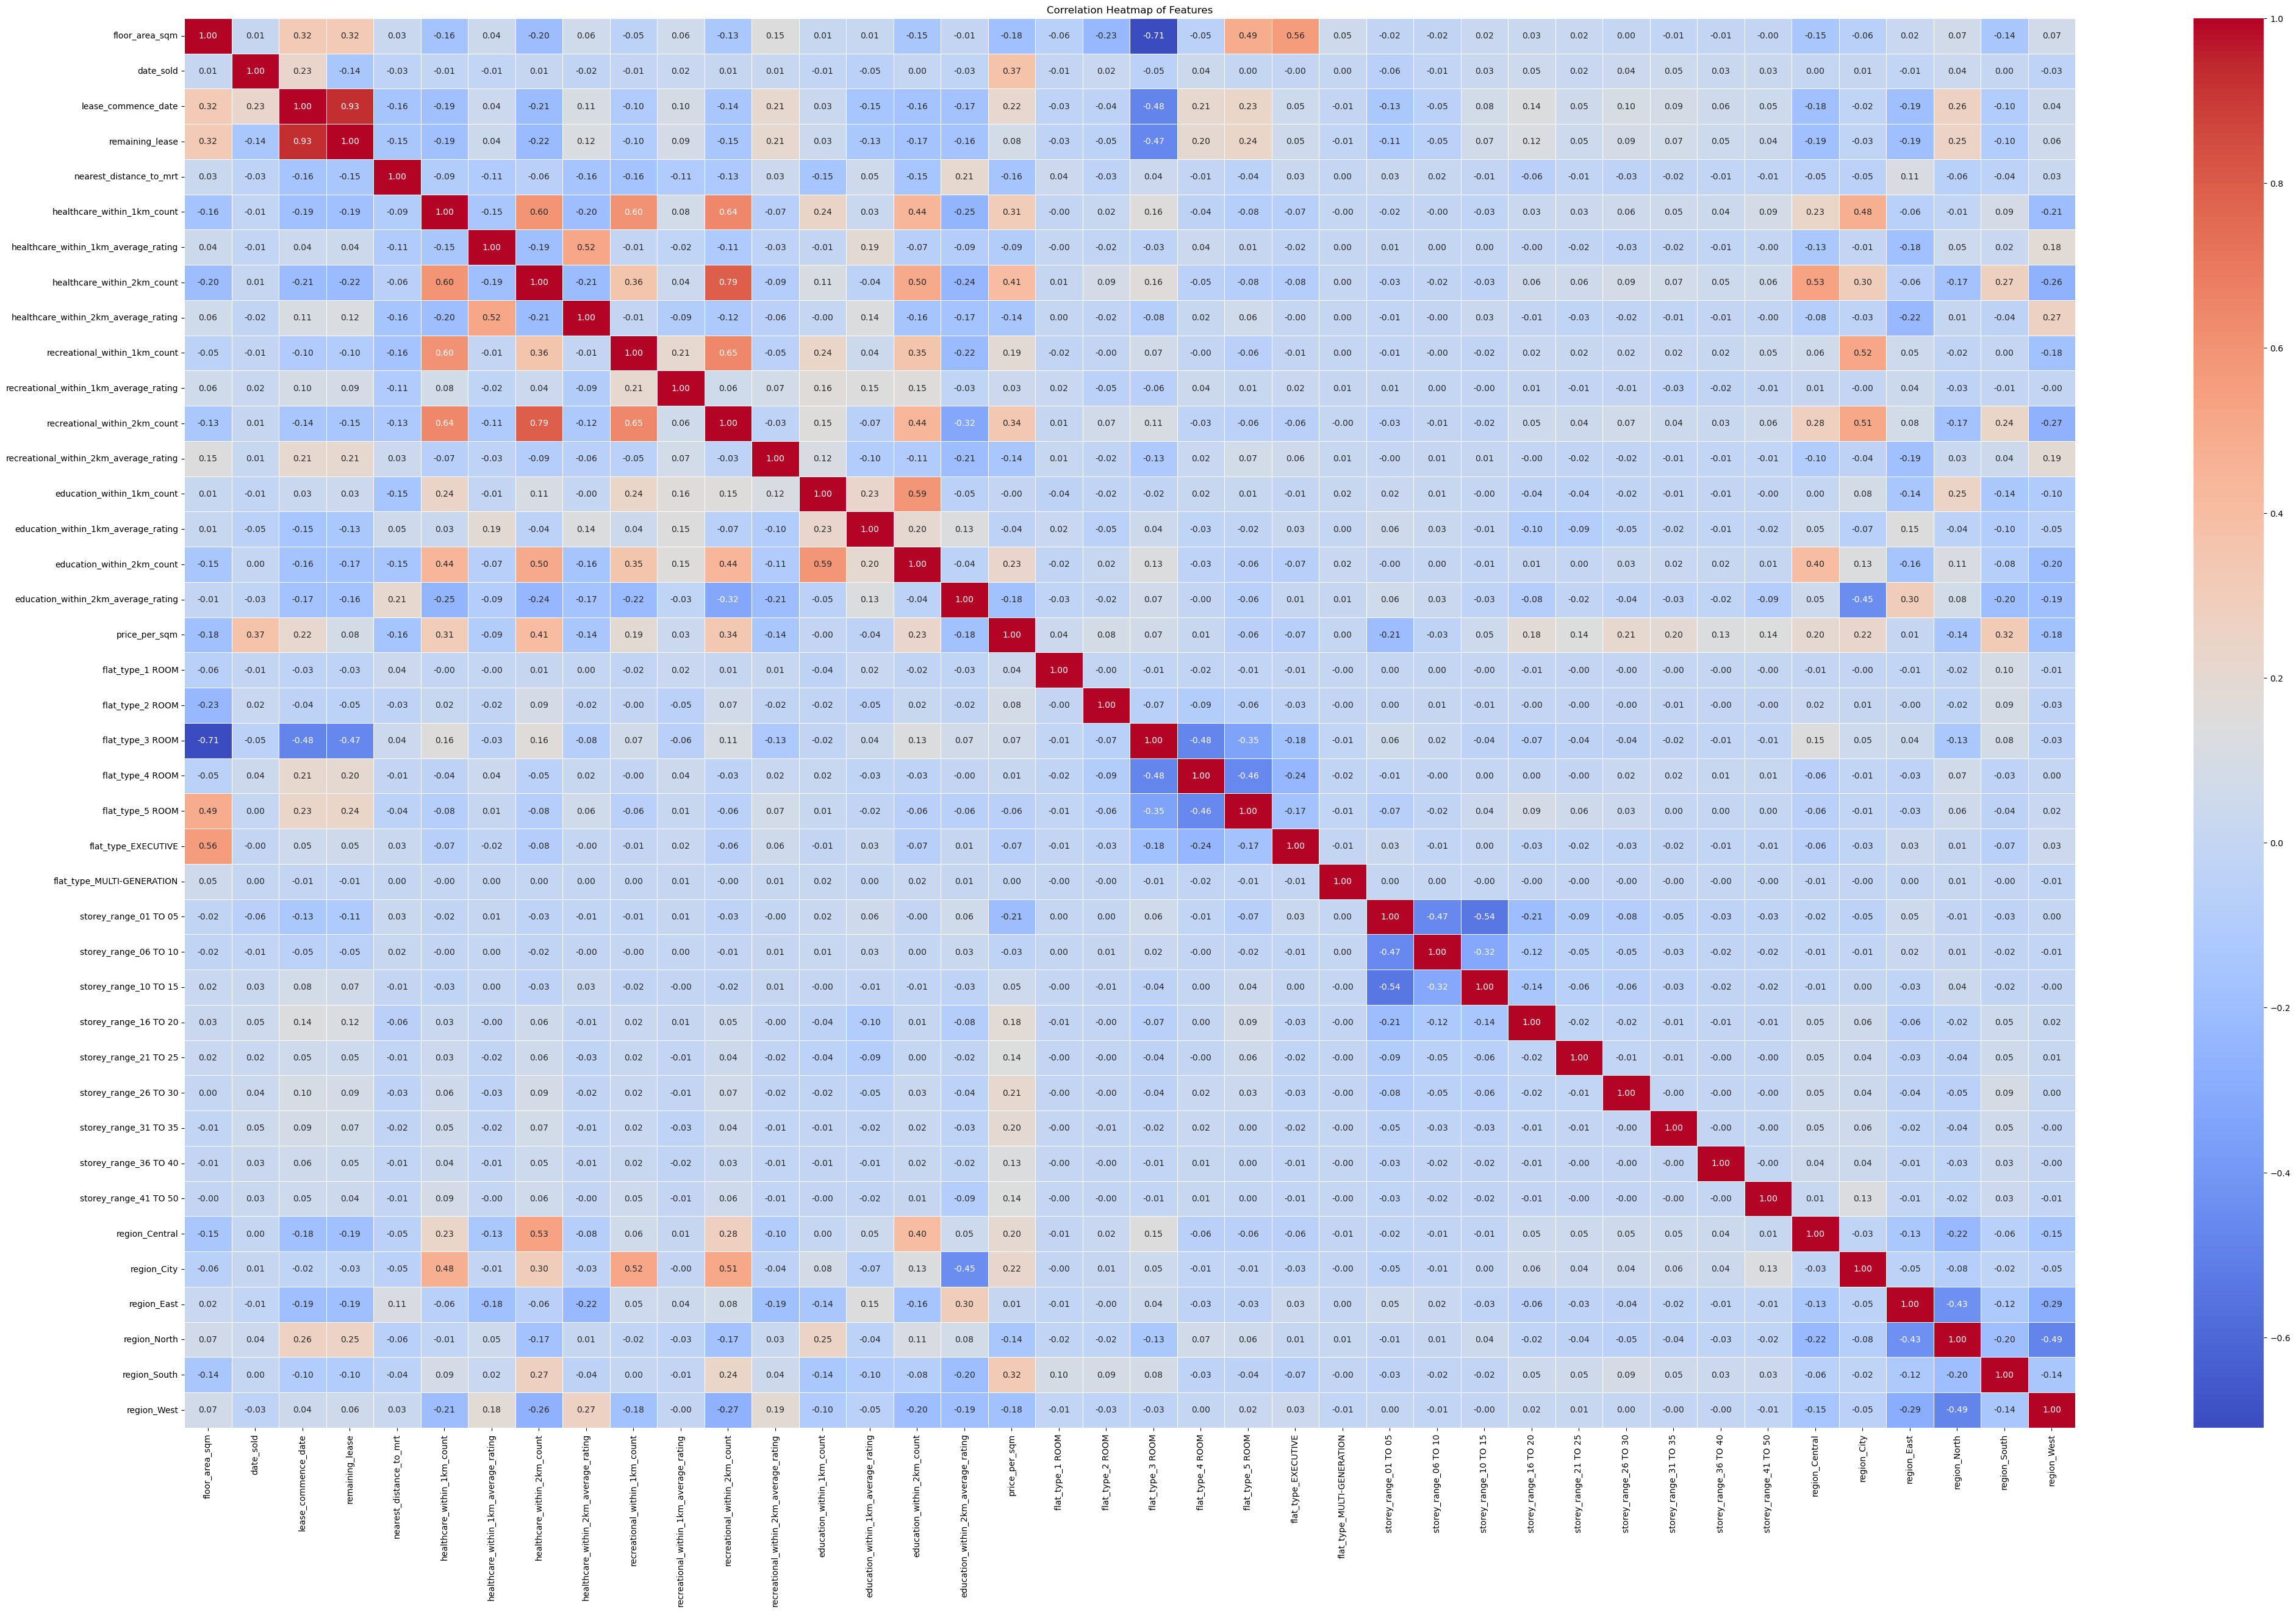

In [16]:
# Compute the correlation matrix
corr_matrix = X_train_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(50, 30))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

# Add a title
plt.title('Correlation Heatmap of Features')

# Show the plot
plt.show()

In [17]:
# Drop Highly Correlated lease_commence_date (with remaining_lease)
X_train_numeric = X_train_numeric.drop(columns=['lease_commence_date'])
X_test_numeric = X_test_numeric.drop(columns=['lease_commence_date'])

In [18]:
# Initialize VarianceThreshold with the desired threshold
threshold = 0.05
selector = VarianceThreshold(threshold)

# Fit the selector to your data
selector.fit(X_train_numeric)

# Get the indices of all features
all_indices = range(len(X_train_numeric.columns))

# Get the indices of the features that are retained
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X_train_numeric.columns[selected_indices]

# Display the selected features
print("Selected features:", selected_features)

# Get the indices of the features that are not selected
not_selected_indices = list(set(all_indices) - set(selected_indices))

# Get the names of the features that are not selected
not_selected_features = X_train_numeric.columns[not_selected_indices]

# Display the features that are not selected
print("Not selected features:", not_selected_features)

Selected features: Index(['floor_area_sqm', 'remaining_lease', 'nearest_distance_to_mrt',
       'healthcare_within_1km_count', 'healthcare_within_1km_average_rating',
       'healthcare_within_2km_count', 'healthcare_within_2km_average_rating',
       'recreational_within_1km_count',
       'recreational_within_1km_average_rating',
       'recreational_within_2km_count', 'education_within_1km_count',
       'education_within_1km_average_rating', 'education_within_2km_count',
       'price_per_sqm', 'flat_type_3 ROOM', 'flat_type_4 ROOM',
       'flat_type_5 ROOM', 'flat_type_EXECUTIVE', 'storey_range_01 TO 05',
       'storey_range_06 TO 10', 'storey_range_10 TO 15', 'region_Central',
       'region_East', 'region_North', 'region_South', 'region_West'],
      dtype='object')
Not selected features: Index(['region_City', 'recreational_within_2km_average_rating',
       'education_within_2km_average_rating', 'flat_type_1 ROOM',
       'flat_type_2 ROOM', 'flat_type_MULTI-GENERATION',
   

In [19]:
# Keep selected features

# Transform your data to keep only the selected features
X_train_selected_array = selector.fit_transform(X_train_numeric)
X_test_selected_array = selector.transform(X_test_numeric)

# Convert the transformed data back to a DataFrame
X_train_selected = pd.DataFrame(X_train_selected_array, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected_array, columns=selected_features)

print(X_train_selected.info())
print(X_test_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253486 entries, 0 to 253485
Data columns (total 26 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   floor_area_sqm                          253486 non-null  object
 1   remaining_lease                         253486 non-null  object
 2   nearest_distance_to_mrt                 253486 non-null  object
 3   healthcare_within_1km_count             253486 non-null  object
 4   healthcare_within_1km_average_rating    253486 non-null  object
 5   healthcare_within_2km_count             253486 non-null  object
 6   healthcare_within_2km_average_rating    253486 non-null  object
 7   recreational_within_1km_count           253486 non-null  object
 8   recreational_within_1km_average_rating  253486 non-null  object
 9   recreational_within_2km_count           253486 non-null  object
 10  education_within_1km_count              253486 non-null 

## Machine Learning Modelling

### Regression Metrics

1. **Mean Absolute Error (MAE)**
   - Formula: $ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $
   - Description: The average of the absolute differences between the predicted values and actual values. It gives an idea of how wrong the predictions were.
   

2. **Mean Absolute Percentage Error (MAPE)**
   - Formula: $ \text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} |\frac{y_i - \hat{y}_i}{y_i}| $
   - Description: Provides an intuitive understanding of model's predictive accuracy relative to actual values. It measures the absolute percentage difference between the predicted values and the actual values.


3. **Mean Squared Error (MSE)**
   - Formula: $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $
   - Description: The average of the squared differences between the predicted values and actual values. It penalizes larger errors more than MAE.


4. **Root Mean Squared Error (RMSE)**
   - Formula: $ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $
   - Description: The square root of the average of the squared differences between the predicted values and actual values. It is in the same units as the response variable and is sensitive to outliers.


5. **R-squared (Coefficient of Determination)**
   - Formula: $ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $
   - Description: The proportion of the variance in the dependent variable that is predictable from the independent variables. It provides a measure of how well observed outcomes are replicated by the model.



In [20]:
# Evaluation 
def evaluate(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    # mape = np.mean(np.abs((np.array(y_test) - np.array(y_pred)) / np.array(y_test))) * 100
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)
    
    print("Mean Absolute Error (MAE):", mae)
    # print("Mean Absolute Percentage Error (MAPE):", mape)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared Coefficient (R^2):", r_squared)

In [21]:
# Features Used
feature_names = X_train_selected.columns

### Baseline Modelling 

We will trial a selected few baseline models to evaluate their performance before selecting the best baseline model to proceed with Hyperparameter Tuning and the subsequent Advanced Modelling which builds on top of Baseline Modelling.

##### Model Training

In [22]:
# Linear Regression
reg_lr = LinearRegression().fit(X_train_selected, y_train)
y_pred_lr = reg_lr.predict(X_test_selected)

evaluate(y_test, y_pred_lr)

Mean Absolute Error (MAE): 15997.765456797359
Mean Squared Error (MSE): 616453880.6893501
Root Mean Squared Error (RMSE): 24828.489295350817
R-squared Coefficient (R^2): 0.9715517505395237


In [23]:
# Decision Tree Regressor
reg_dtr = DecisionTreeRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_dtr = reg_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_dtr)

Mean Absolute Error (MAE): 370.30759142444606
Mean Squared Error (MSE): 6271935.899664233
Root Mean Squared Error (RMSE): 2504.383337203838
R-squared Coefficient (R^2): 0.9997105613207038


Given Decision Tree Regressor outperforms Linear Regression as it has a greater R-Squared Coefficient of 0.99971 > 0.97155, we will be proceeding with Decision Tree Regressor as our baseline model.

##### Cross Validation

<AxesSubplot:title={'center':'Decision Tree Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

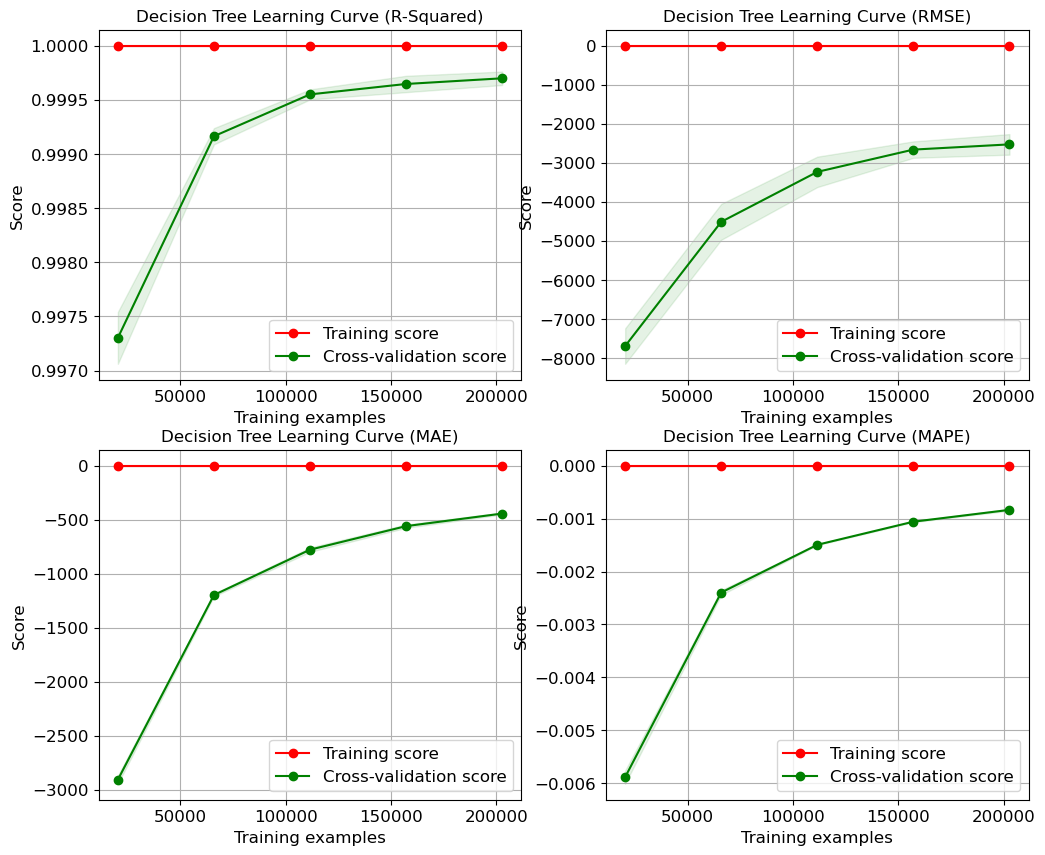

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

# Learning curves
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(DecisionTreeRegressor(random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Decision Tree Learning Curve (MAPE)", ax=ax4)

Training Score Curve shows the model's performance based on the training dataset as a function of the number of training examples used. Validation Score Curve shows the model's performance on a separate validation dataset as a function of the number of training examples used. 

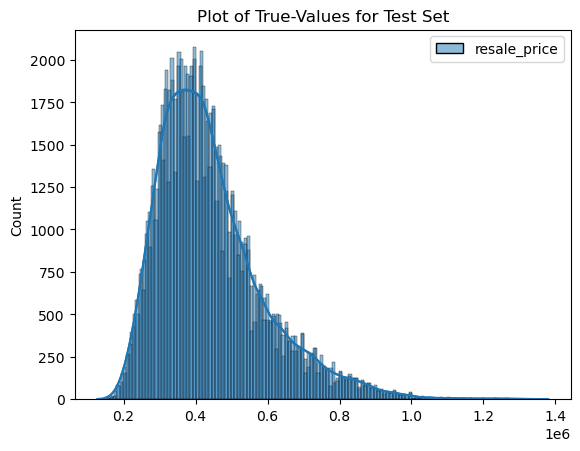

In [25]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_dtr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

In [26]:
# Print Text Representation of Decision Tree Regressor rules
text_representation_dtr = tree.export_text(reg_dtr)
print(text_representation_dtr)

|--- feature_0 <= 84.50
|   |--- feature_13 <= 5889.65
|   |   |--- feature_13 <= 4340.92
|   |   |   |--- feature_0 <= 74.50
|   |   |   |   |--- feature_13 <= 3752.77
|   |   |   |   |   |--- feature_13 <= 3418.55
|   |   |   |   |   |   |--- feature_0 <= 65.50
|   |   |   |   |   |   |   |--- feature_13 <= 3137.03
|   |   |   |   |   |   |   |   |--- feature_0 <= 62.50
|   |   |   |   |   |   |   |   |   |--- feature_14 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_9 <= 10.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_9 >  10.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [140000.00]
|   |   |   |   |   |   |   |   |   |--- feature_14 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_13 <= 2525.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_13 >  2525.00
|   |   |   |   |   |

##### Hyperparameter Tuning

In [27]:
# Decision Tree Model Parameters
reg_dtr.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [28]:
# https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
    
# Use RandomSearch 
param_dist = {
    "max_depth": randint(1, 20),  
    "min_samples_split": randint(2, 40),  
    "min_samples_leaf": randint(1, 20), 
    "max_features": ["auto", "sqrt", "log2", None],
}

rscv_dtr = RandomizedSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_distributions = param_dist, n_iter = 100, scoring = 'neg_root_mean_squared_error', cv = 5, n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = rscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_rscv_dtr = rscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_rscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 17, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 8}
Mean Absolute Error (MAE): 817.1716910933172
Mean Squared Error (MSE): 12064228.69661777
Root Mean Squared Error (RMSE): 3473.3598570573954
R-squared Coefficient (R^2): 0.9994432573169532


In [29]:
# Use Grid Search
params = { 
    'max_depth': [5, 10, 12, 15, 17, 20],     
    'min_samples_split': [2, 5, 10, 15, 20, 40], 
    'min_samples_leaf': [1, 3, 5, 7, 10, 20],
    "max_features": ['auto', None],
}

gscv_dtr = GridSearchCV(estimator = DecisionTreeRegressor(random_state=42), param_grid = params, scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_dtr = gscv_dtr.best_params_
print("Best Parameters For Decision Tree:", best_params_dtr)

y_pred_gscv_dtr = gscv_dtr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_dtr)

Best Parameters For Decision Tree: {'max_depth': 17, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}
Mean Absolute Error (MAE): 402.732339277825
Mean Squared Error (MSE): 5152119.221235374
Root Mean Squared Error (RMSE): 2269.828015783437
R-squared Coefficient (R^2): 0.9997622388674203


After Hyperparameter Tuning, the RMSE of the tuned model has decreased from 2504 to 2270 when compared to the model before Hyperparameter Tuning. The best hyperparameters are 'max_depth': 17, 'max_features': 'auto', 'min_samples_leaf': 1 and 'min_samples_split': 5.

##### Feature Evaluation

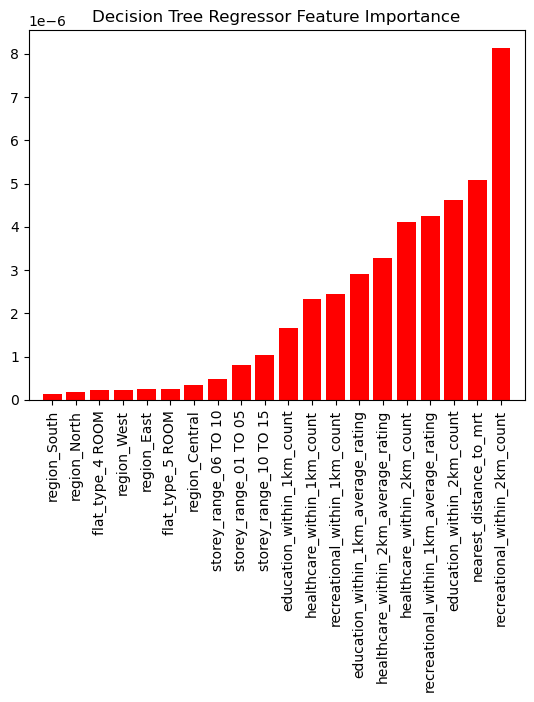

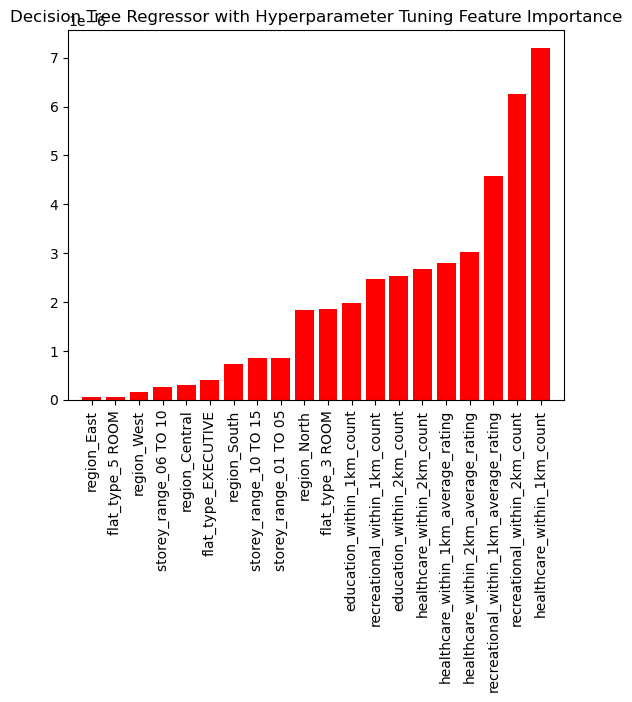

In [ ]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_dtr, feature_names = feature_names,
                                         title="Decision Tree Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(gscv_dtr.best_estimator_, feature_names = feature_names,
                                         title="Decision Tree Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The Decision Tree Regressor Feature Importance plot displays the significance of each attribute in the regression model. The features, labeled on the x-axis, are ranked according to their importance scores on the y-axis. A higher bar denotes a greater influence on the model's predictions, with "recreational_within_2km_count" standing out as the most impactful feature in this particular model. However, after hyperparameter tuning, "healthcare_within_1km_count" stood out as the most impactful feature in this particular model.

### Advanced Modelling 

From the Baseline Decision Tree Model, we will look into more complex Ensemble models for better performance.

#### Random Forest Regressor

In [ ]:
# Random Forest Regressor
reg_rfr = RandomForestRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_rfr = reg_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_rfr)

Mean Absolute Error (MAE): 251.47289441513638
Mean Squared Error (MSE): 4011083.9197759186
Root Mean Squared Error (RMSE): 2002.7690630164823
R-squared Coefficient (R^2): 0.9998148956158259


##### Cross Validation

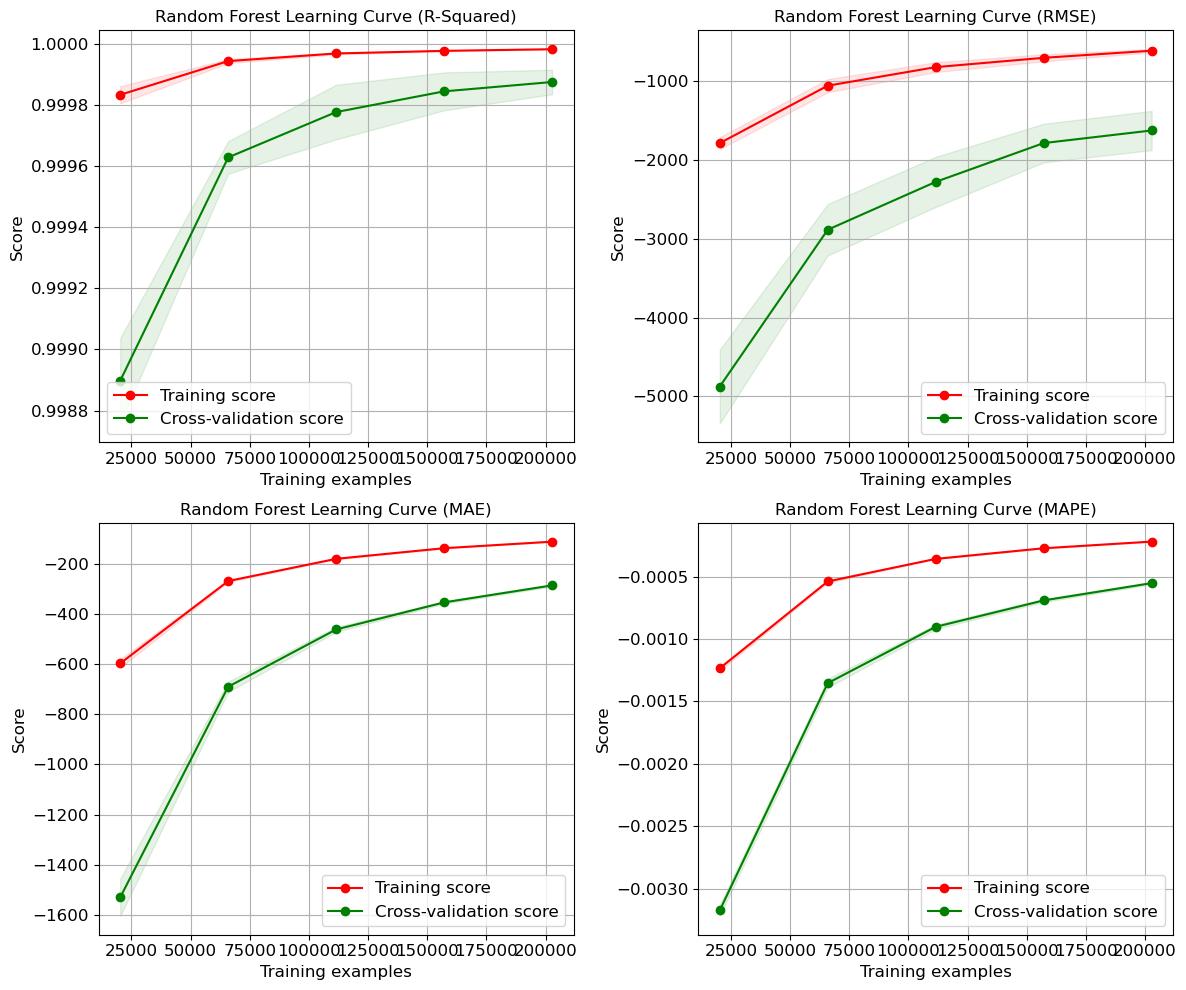

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 
y_train_reshaped = np.ravel(y_train)

# Learning curves
skplt.estimators.plot_learning_curve(RandomForestRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(RandomForestRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(RandomForestRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(RandomForestRegressor(random_state=42), X_train_selected, y_train_reshaped,
                                     cv=5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6, 4), title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Learning Curve (MAPE)", ax=ax4)

plt.tight_layout()
plt.show()



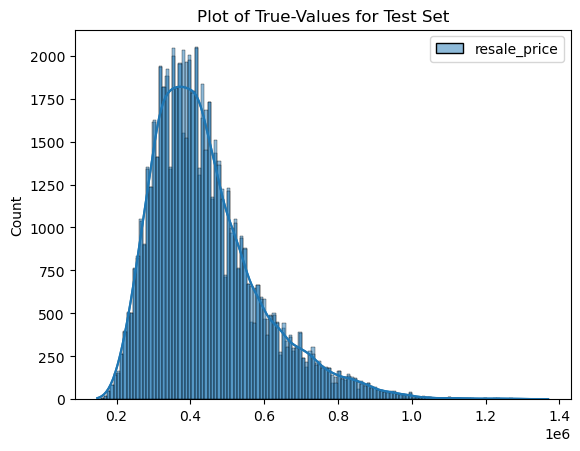

In [ ]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_rfr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

##### Hyperparameter Tuning

In [ ]:
# Random Forest Model Parameters
reg_rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Use Grid Search
y_train_reshaped = np.ravel(y_train)

params = { 
    'max_depth': [5, 10, 12, 15, 17, 20],     
    'min_samples_split': [2, 5, 10, 15, 20, 40], 
    'min_samples_leaf': [1, 3, 5, 7, 10, 20],
    "max_features": ['auto', None],
}

gscv_rfr = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                        param_grid=params, 
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1)
gscv_rfr.fit(X_train_selected, y_train_reshaped)

best_params_rfr = gscv_rfr.best_params_
print("Best Parameters For Random Forest:", best_params_rfr)

y_pred_gscv_rfr = gscv_rfr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_rfr)

Best Parameters For Random Forest: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Absolute Error (MAE): 250.03361383760472
Mean Squared Error (MSE): 3891485.9174014186
Root Mean Squared Error (RMSE): 1972.6849513800776
R-squared Coefficient (R^2): 0.9998204148507811


After Hyperparameter Tuning, the RMSE of the tuned model has decreased from 2002 to 1973 when compared to the model before Hyperparameter Tuning. The best hyperparameters are 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2.

##### Feature Evaluation

In [ ]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_rfr, feature_names = feature_names,
                                         title="Random Forest Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(gscv_rfr.best_estimator_, feature_names = feature_names,
                                         title="Random Forest Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The Random Forest Regressor Feature Importance plot displays the significance of each attribute in the regression model. A higher bar denotes a greater influence on the model's predictions, with "feature_name" standing out as the most impactful feature in this particular model. However, after hyperparameter tuning, "feature_name" stood out as the most impactful feature in this particular model.

#### XGBoost Regressor

In [38]:
reg_xgbr = XGBRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_xgbr = reg_xgbr.predict(X_test_selected)

evaluate(y_test, y_pred_xgbr)

Mean Absolute Error (MAE): 2372.772940770372
Mean Squared Error (MSE): 19901136.969587162
Root Mean Squared Error (RMSE): 4461.06903887254
R-squared Coefficient (R^2): 0.9990815979478873


##### Cross Validation

<Axes: title={'center': 'XGBoost Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

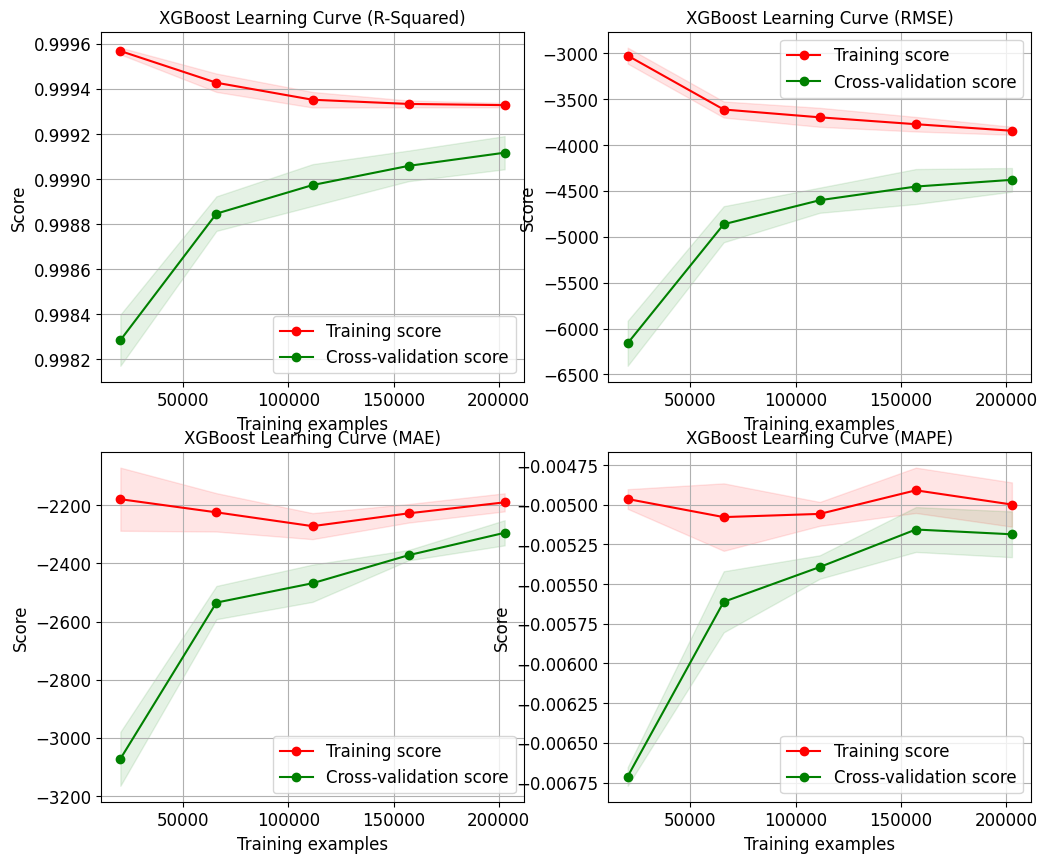

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

cv_xgbr = XGBRegressor(random_state=42)

# Learning curves
skplt.estimators.plot_learning_curve(cv_xgbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="XGBoost Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(cv_xgbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="XGBoost Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(cv_xgbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="XGBoost Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(cv_xgbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="XGBoost Learning Curve (MAPE)", ax=ax4)

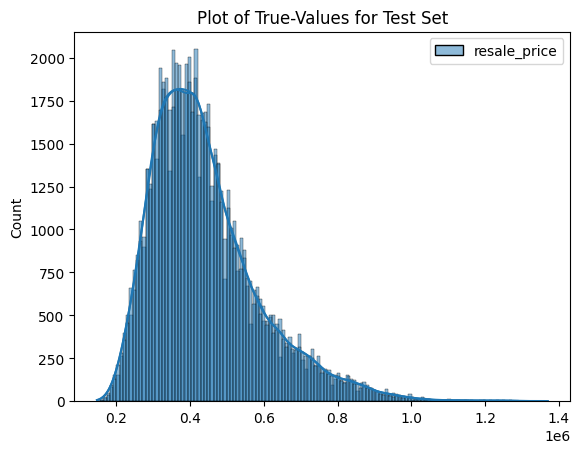

In [40]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_xgbr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

##### Hyperparameter Tuning

In [41]:
# XGBoost Model Parameters
reg_xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d
# Define the hyperparameter distributions
param_dist = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.5, 0.5),
}

rscv_xgb = RandomizedSearchCV(estimator= XGBRegressor(random_state=42), param_distributions=param_dist, n_iter=100, scoring='neg_root_mean_squared_error', cv = 5, n_jobs = -1).fit(X_train_selected, y_train)

best_params_xgb = rscv_xgb.best_params_
print("Best Parameters for XGBoost: ", best_params_xgb)

y_pred_rscv_xgb = rscv_xgb.predict(X_test_selected)

evaluate(y_test, y_pred_rscv_xgb)

In [48]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 12, 15, 17, 20],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}
gscv_xgb = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid = param_grid, scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_xgb = gscv_xgb.best_params_
print("Best Parameters for XGBoost: ", best_params_xgb)

y_pred_gscv_xgb = gscv_xgb.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_xgb)

Best Parameters for XGBoost:  {'learning_rate': 0.1, 'max_depth': 10, 'subsample': 1}
Mean Absolute Error (MAE): 988.4249036344916
Mean Squared Error (MSE): 12171310.6114664
Root Mean Squared Error (RMSE): 3488.7405480296757
R-squared Coefficient (R^2): 0.9994383156771619


After Hyperparameter Tuning, the RMSE of the tuned model has decreased from 4461 to 3489 when compared to the model before Hyperparameter Tuning. The best hyperparameters are 'learning_rate': 0.1, 'max_depth': 10, 'subsample': 1.

##### Feature Evaluation

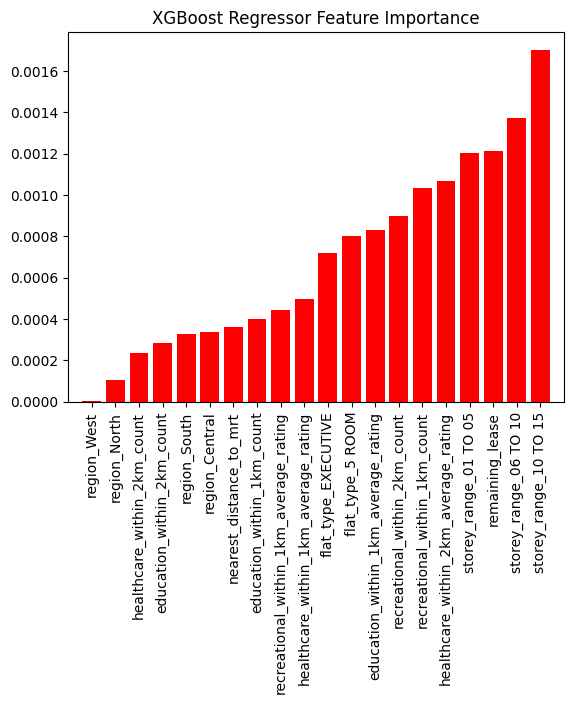

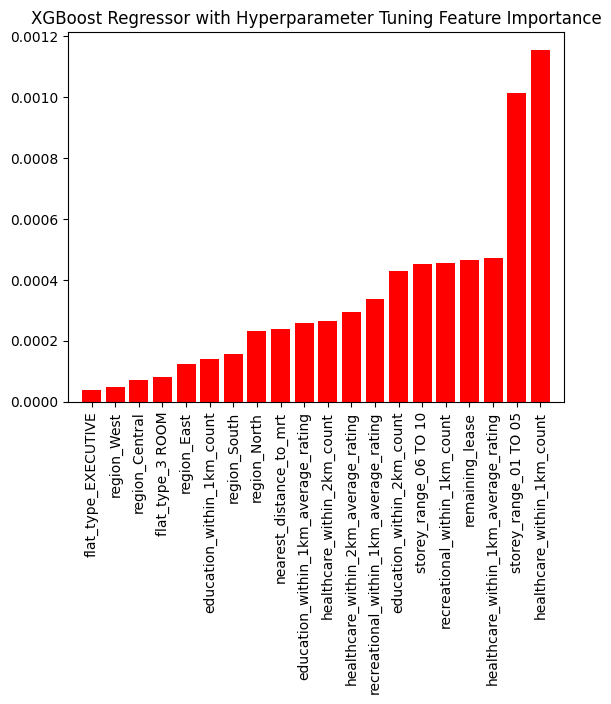

In [43]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_xgbr, feature_names = feature_names,
                                         title="XGBoost Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(rscv_xgb.best_estimator_, feature_names = feature_names,
                                         title="XGBoost Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order='ascending');

The XG Boost Regressor Feature Importance plot displays the significance of each attribute in the regression model. A higher bar denotes a greater influence on the model's predictions, with "storey_range 10 TO 15" standing out as the most impactful feature in this particular model. However, after hyperparameter tuning, "healthcare_within_1km_count" stood out as the most impactful feature in this particular model.

#### LightGBM Regressor

In [ ]:
reg_lgbmr = lgb.LGBMRegressor(random_state=42).fit(X_train_selected, y_train)
y_pred_lgbmr = reg_lgbmr.predict(X_test_selected)

evaluate(y_test, y_pred_lgbmr)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 253486, number of used features: 26
[LightGBM] [Info] Start training from score 441218.283720
Mean Absolute Error (MAE): 2670.081639494893
Mean Squared Error (MSE): 24148170.204100728
Root Mean Squared Error (RMSE): 4914.078774714619
R-squared Coefficient (R^2): 0.9988856049227688


##### Cross Validation

<Axes: title={'center': 'LightGBM Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

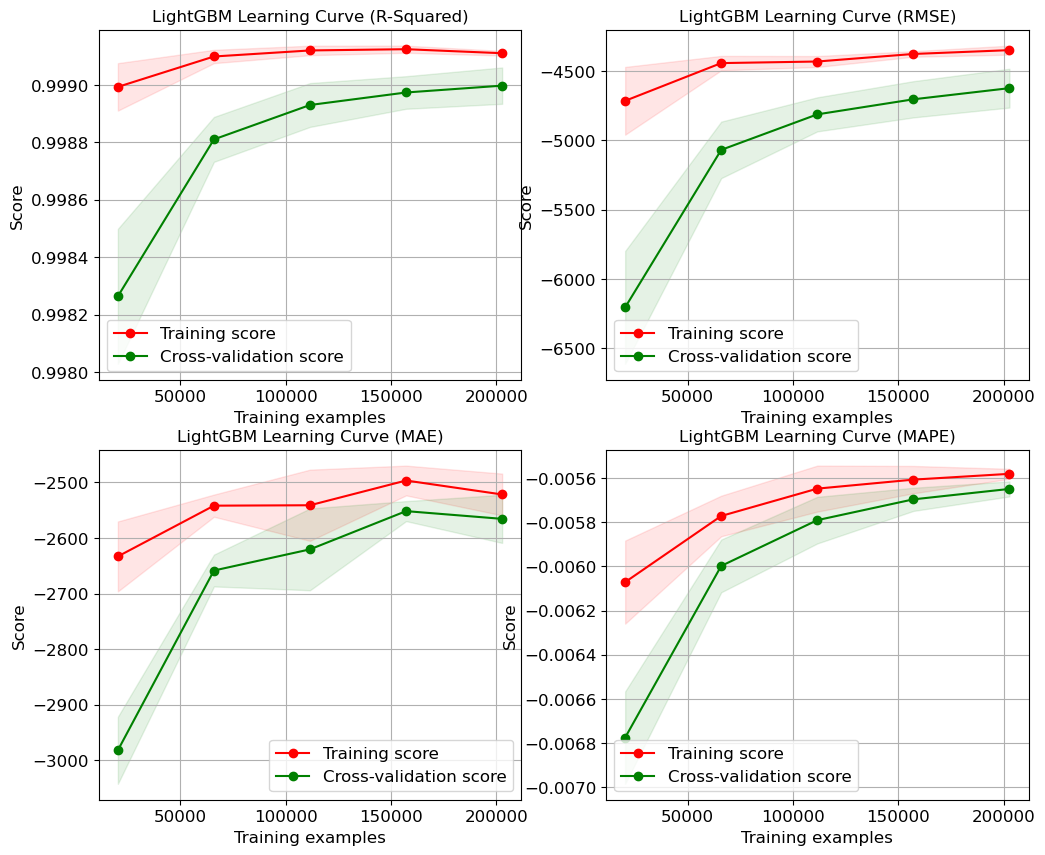

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

cv_lgmbr = lgb.LGBMRegressor(random_state=42)

# Learning curves
skplt.estimators.plot_learning_curve(cv_lgmbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(cv_lgmbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(cv_lgmbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(cv_lgmbr, X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="LightGBM Learning Curve (MAPE)", ax=ax4)

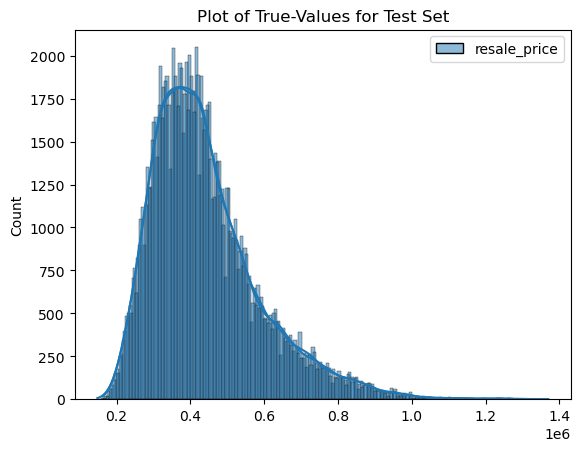

In [ ]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_lgmbr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

##### Hyperparameter Tuning

In [ ]:
reg_lgbmr.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# num_leaves shoud be < 2^(max_depth)

# random search
params = { 
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'num_leaves': randint(5, 500),
    'min_data_in_leaf': randint(5, 500),
    'learning_rate': [0.01, 0.05, 0.10, 0.50],
}

rand_search_lgbm = RandomizedSearchCV(estimator = lgb.LGBMRegressor(random_state=42), param_distributions = params,
                                       scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_lgbm = rand_search_lgbm.best_params_
print("Best Parameters For LightGBM:", best_params_lgbm)

y_pred_gscv_cbr = rand_search_lgbm.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_cbr)

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 253486, number of used features: 26
[LightGBM] [Info] Start training from score 441218.283720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

After Hyperparameter Tuning, the RMSE of the tuned model has decreased from 4914 to 4005 when compared to the model before Hyperparameter Tuning. The best hyperparameters are 'learning_rate': 0.1, 'max_depth': 8, 'min_data_in_leaf': 15 and 'num_leaves': 82.

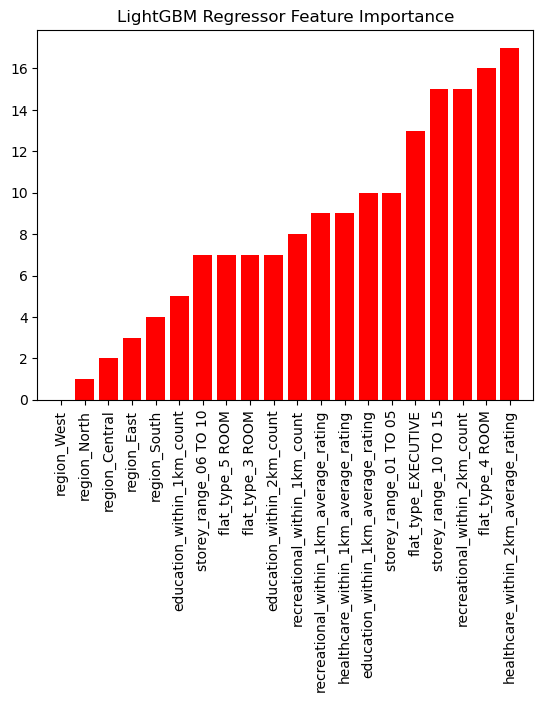

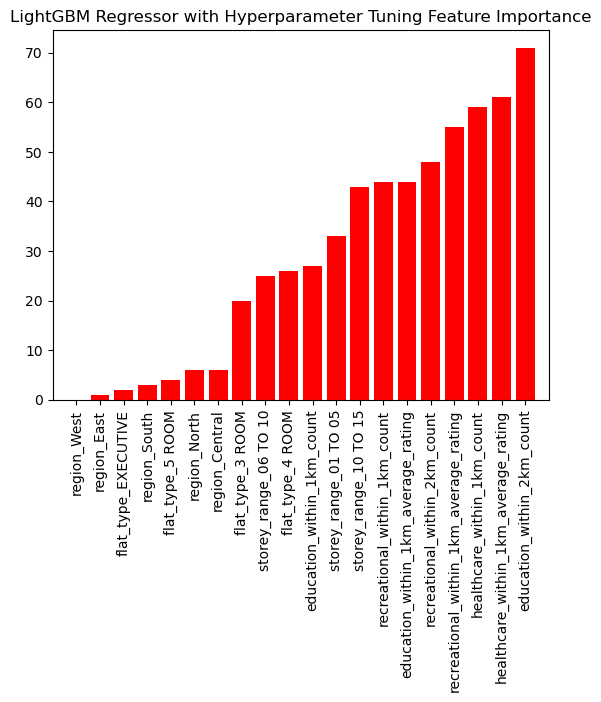

In [ ]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_lgbmr, feature_names = feature_names,
                                         title="LightGBM Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(rand_search_lgbm.best_estimator_, feature_names = feature_names,
                                         title="LightGBM Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The LightGBM Regressor Feature Importance plot displays the significance of each attribute in the regression model, where a higher bar would denote that the attriubute a greater influence on the model's predictions. For this model, "healthcare_within_2km_average_rating" stands out as the most impactful feature. However, after hyperparameter tuning, "education_within_2km_count" seems to be the most impactful feature.

#### CatBoost Regressor

In [32]:
reg_cbr = cb.CatBoostRegressor(n_estimators = 100, random_state=42).fit(X_train_selected, y_train)
y_pred_cbr = reg_cbr.predict(X_test_selected)

evaluate(y_test, y_pred_cbr)

Learning rate set to 0.5
0:	learn: 84948.9769426	total: 179ms	remaining: 17.7s
1:	learn: 53643.2102938	total: 211ms	remaining: 10.3s
2:	learn: 37447.0330737	total: 234ms	remaining: 7.56s
3:	learn: 28224.8804968	total: 254ms	remaining: 6.09s
4:	learn: 22518.6583547	total: 274ms	remaining: 5.2s
5:	learn: 19953.5887475	total: 291ms	remaining: 4.55s
6:	learn: 18613.4003280	total: 309ms	remaining: 4.11s
7:	learn: 17729.9829120	total: 327ms	remaining: 3.76s
8:	learn: 16289.8298694	total: 351ms	remaining: 3.55s
9:	learn: 15604.0728374	total: 371ms	remaining: 3.34s
10:	learn: 14766.6137568	total: 387ms	remaining: 3.13s
11:	learn: 14248.4891018	total: 410ms	remaining: 3.01s
12:	learn: 13002.5115307	total: 434ms	remaining: 2.9s
13:	learn: 12721.0193023	total: 449ms	remaining: 2.76s
14:	learn: 12232.7375958	total: 469ms	remaining: 2.66s
15:	learn: 11591.1402949	total: 492ms	remaining: 2.58s
16:	learn: 11246.0004112	total: 512ms	remaining: 2.5s
17:	learn: 10815.3097349	total: 530ms	remaining: 2.41

##### Cross Validation

<AxesSubplot:title={'center':'Cat Boost Learning Curve (MAPE)'}, xlabel='Training examples', ylabel='Score'>

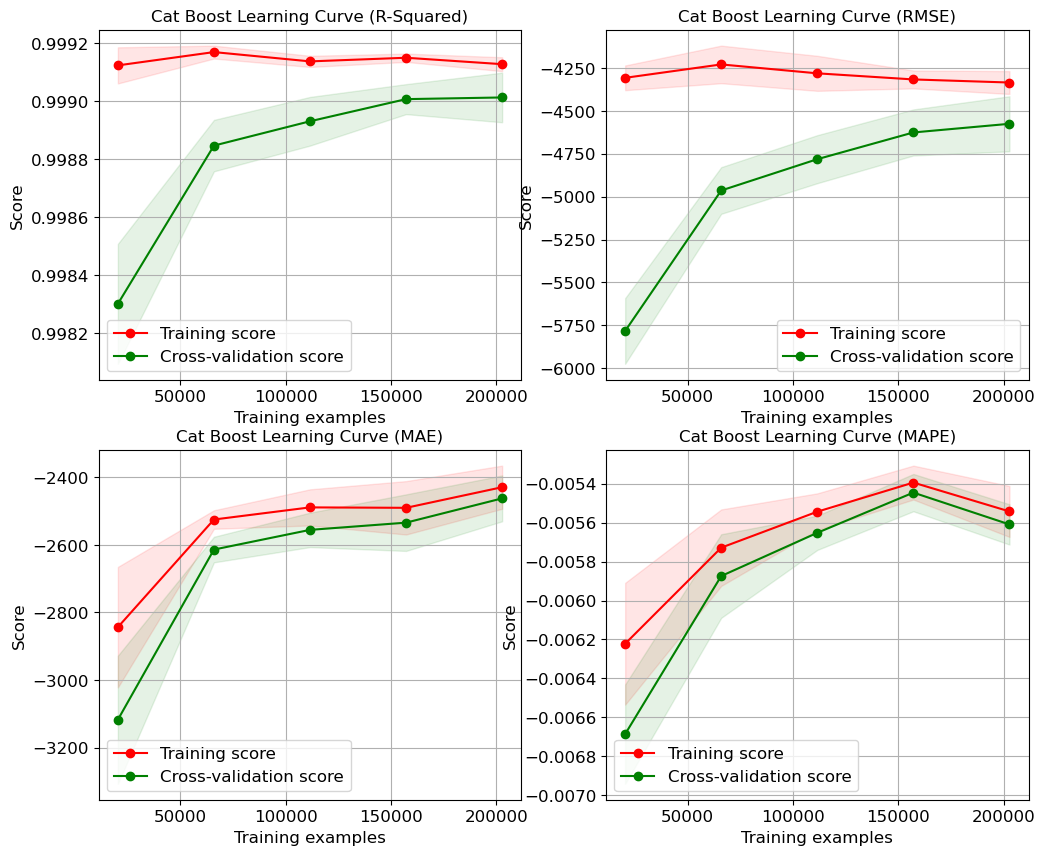

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
ax1, ax2, ax3, ax4 = axes.flatten() 

# Learning curves
skplt.estimators.plot_learning_curve(cb.CatBoostRegressor(n_estimators = 100, random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="r2", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Cat Boost Learning Curve (R-Squared)", ax=ax1)
skplt.estimators.plot_learning_curve(cb.CatBoostRegressor(n_estimators = 100, random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_root_mean_squared_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Cat Boost Learning Curve (RMSE)", ax=ax2)
skplt.estimators.plot_learning_curve(cb.CatBoostRegressor(n_estimators = 100, random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Cat Boost Learning Curve (MAE)", ax=ax3)
skplt.estimators.plot_learning_curve(cb.CatBoostRegressor(n_estimators = 100, random_state=42), X_train_selected, y_train,
                                     cv = 5, shuffle=True, scoring="neg_mean_absolute_percentage_error", n_jobs=-1,
                                     figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title="Cat Boost Learning Curve (MAPE)", ax=ax4)

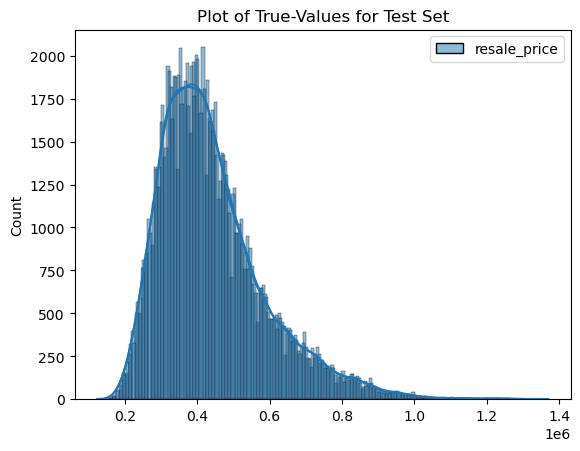

In [34]:
# Plot graph to visualise how far predictions are from true-values for test set
sns.histplot(y_test, label='true', color='red', kde=True)
sns.histplot(y_pred_cbr, label='predicted', kde=True)
plt.title("Plot of True-Values for Test Set")
plt.show()

##### Hyperparameter Tuning

In [35]:
# https://catboost.ai/en/docs/concepts/python-reference_catboostregressor

# Cat Boost Model Parameters
reg_cbr.get_params()

{'loss_function': 'RMSE', 'n_estimators': 100, 'random_state': 42}

In [37]:
# https://catboost.ai/en/docs/concepts/parameter-tuning

# Use GridSearch 
params = {
    'learning_rate': [0.10, 0.50],
    'depth': [4, 5, 6, 7, 8, 9, 10],
}

gscv_cbr = GridSearchCV(estimator = cb.CatBoostRegressor(n_estimators = 100, random_state=42), param_grid = params, scoring = 'neg_root_mean_squared_error', n_jobs = -1).fit(X_train_selected, y_train)

best_params_cbr = gscv_cbr.best_params_
print("Best Parameters For Cat Boost:", best_params_cbr)

y_pred_gscv_cbr = gscv_cbr.predict(X_test_selected)

evaluate(y_test, y_pred_gscv_cbr)

0:	learn: 81862.6204344	total: 240ms	remaining: 23.7s
1:	learn: 47895.4640090	total: 453ms	remaining: 22.2s
2:	learn: 29630.6830584	total: 704ms	remaining: 22.8s
3:	learn: 21217.4252134	total: 882ms	remaining: 21.2s
4:	learn: 16590.6180060	total: 1.09s	remaining: 20.7s
5:	learn: 14502.9698152	total: 1.26s	remaining: 19.8s
6:	learn: 13272.6096800	total: 1.45s	remaining: 19.2s
7:	learn: 12163.2612770	total: 1.6s	remaining: 18.4s
8:	learn: 11404.4323678	total: 1.77s	remaining: 17.9s
9:	learn: 10495.0321376	total: 1.95s	remaining: 17.5s
10:	learn: 10082.0281977	total: 2.11s	remaining: 17s
11:	learn: 9505.7224276	total: 2.33s	remaining: 17.1s
12:	learn: 9174.3665204	total: 2.54s	remaining: 17s
13:	learn: 8721.4703811	total: 2.74s	remaining: 16.8s
14:	learn: 8190.1926662	total: 2.91s	remaining: 16.5s
15:	learn: 8006.2240790	total: 3.09s	remaining: 16.2s
16:	learn: 7759.1897406	total: 3.26s	remaining: 15.9s
17:	learn: 7533.1664118	total: 3.42s	remaining: 15.6s
18:	learn: 7344.1495224	total: 3

After Hyperparameter Tuning, the RMSE of the tuned model has decreased from 4665 to 4160 when compared to the model before Hyperparameter Tuning. The best hyperparameters are 'depth': 10 and 'learning_rate': 0.5.

##### Feature Evaluation

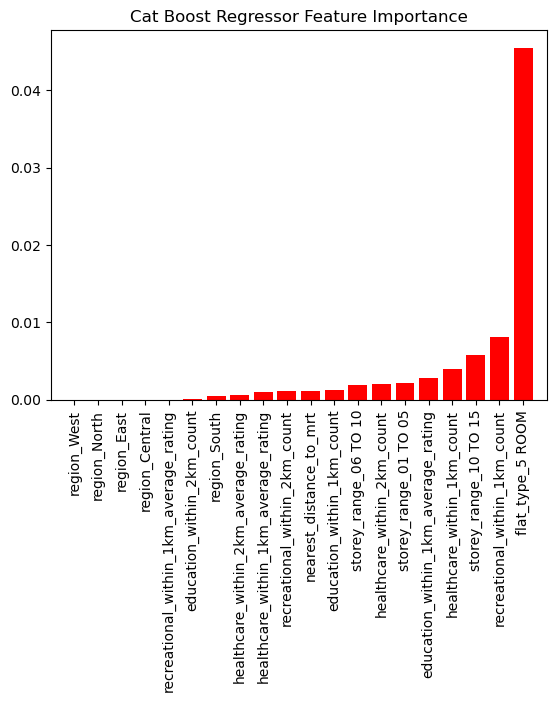

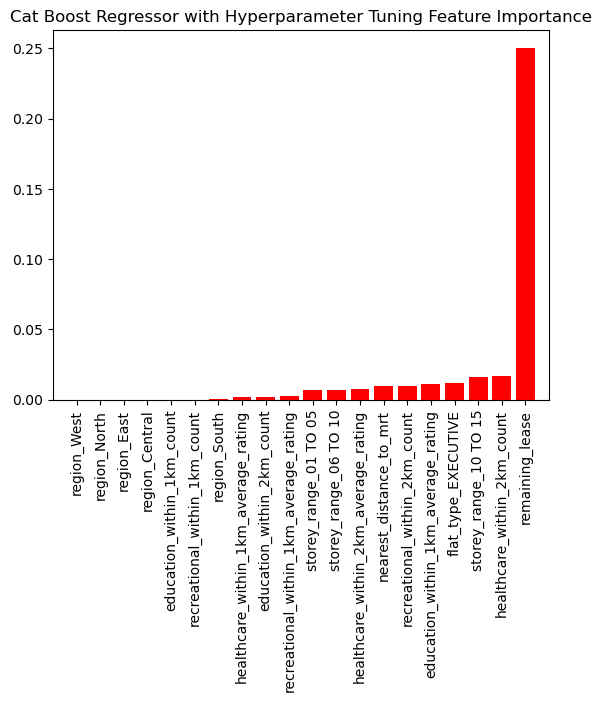

In [38]:
# Feature Importance Visualisation
skplt.estimators.plot_feature_importances(reg_cbr, feature_names = feature_names,
                                         title="Cat Boost Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending");
skplt.estimators.plot_feature_importances(gscv_cbr.best_estimator_, feature_names = feature_names,
                                         title="Cat Boost Regressor with Hyperparameter Tuning Feature Importance",
                                         x_tick_rotation=90, order="ascending");

The Cat Boost Regressor Feature Importance plot displays the significance of each attribute in the regression model. A higher bar denotes a greater influence on the model's predictions, with "flat_type 5 ROOM" standing out as the most impactful feature in this particular model. However, after hyperparameter tuning, "remaining_lease" stood out as the most impactful feature in this particular model.

### Models Comparison

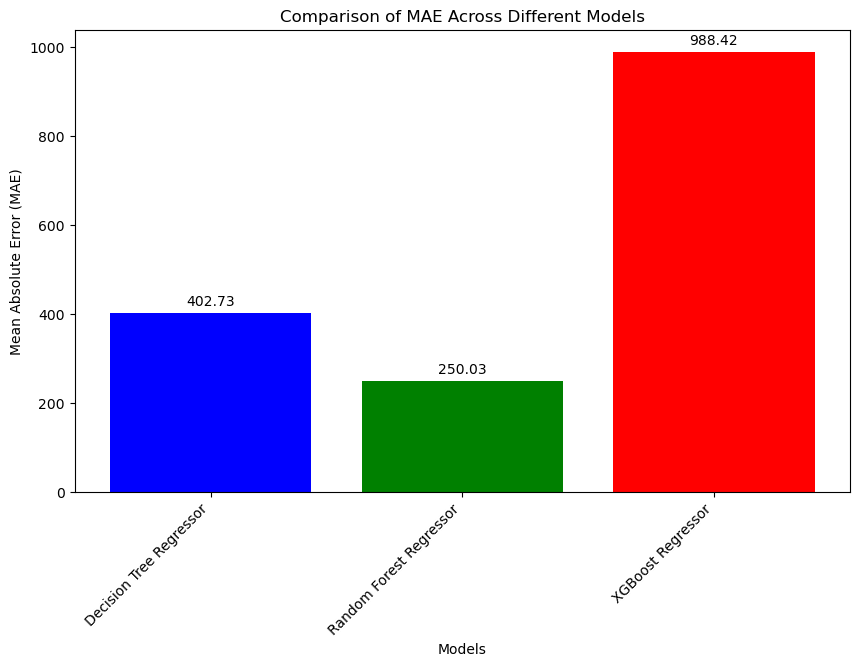

In [45]:
# MAE
mae_dtr = 402.732339277825
mae_rfr = 250.03361383760472
mae_xgb = 988.4249036344916

models = ['Decision Tree Regressor', 'Random Forest Regressor', 'XGBoost Regressor']
mae_values = [mae_dtr, mae_rfr, mae_xgb]

plt.figure(figsize=(10, 6))
mae_bars = plt.bar(models, mae_values, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparison of MAE Across Different Models')
plt.xticks(rotation=45, ha='right')

for bar, value in zip(mae_bars, mae_values):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 10, 
             round(value, 2), 
             ha='center', 
             va='bottom')

plt.show()

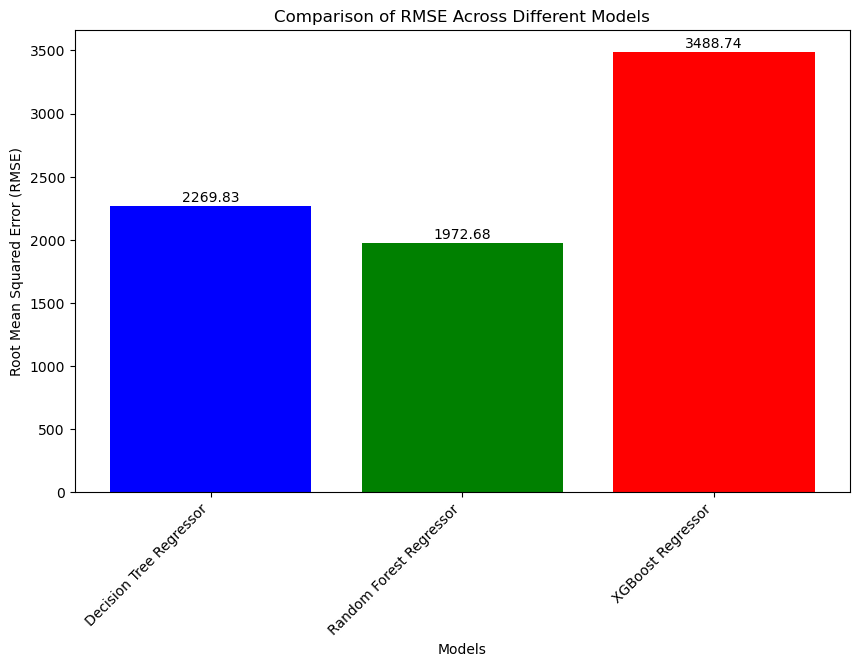

In [46]:
# RMSE
rmse_dtr = 2269.828015783437
rmse_rfr = 1972.6849513800776
rmse_xgb = 3488.7405480296757

rmse_values = [rmse_dtr, rmse_rfr, rmse_xgb]

plt.figure(figsize=(10, 6))
rmse_bars = plt.bar(models, rmse_values, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of RMSE Across Different Models')
plt.xticks(rotation=45, ha='right')

for bar, value in zip(rmse_bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 10, 
             round(value, 2), 
             ha='center', 
             va='bottom')

plt.show()

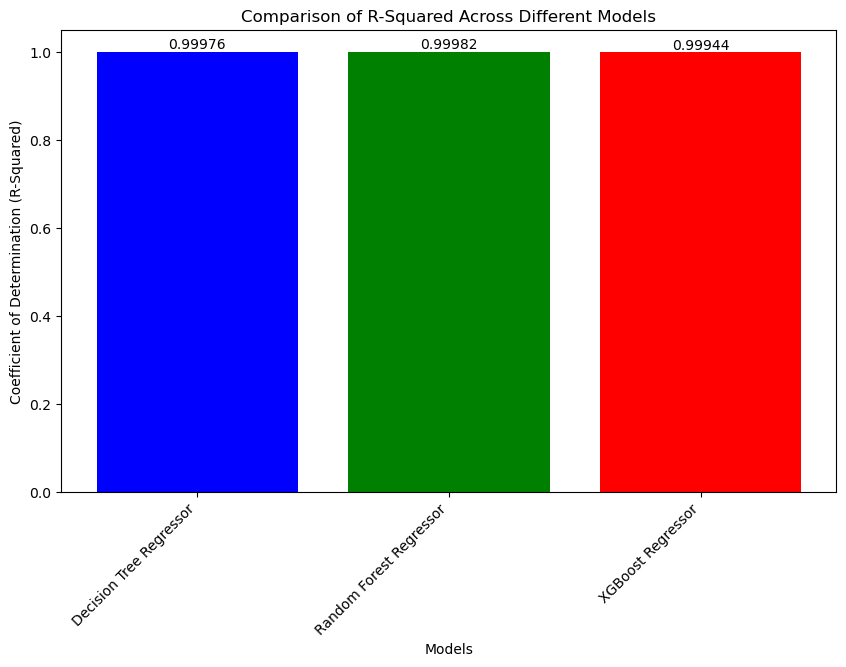

In [50]:
# R-Squared
r2_dtr = 0.9997622388674203
r2_rfr = 0.9998204148507811
r2_xgb = 0.9994383156771619

r2_values = [r2_dtr, r2_rfr, r2_xgb]

plt.figure(figsize=(10, 6))
r2_bars = plt.bar(models, r2_values, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Coefficient of Determination (R-Squared)')
plt.title('Comparison of R-Squared Across Different Models')
plt.xticks(rotation=45, ha='right')

for bar, value in zip(r2_bars, r2_values):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height() + 0, 
             round(value, 5), 
             ha='center', 
             va='bottom')

plt.show()

### Conclusion

Based on the model trainings of the 4 advanced models, Random Forest Regressor is the best performing model with the highest coefficient of determination of 0.99982 and the lowest RMSE of 1973. The rankings for the performance of the advanced models are as follows Random Forest Regressor > XG Boost Regressor > Cat Boost Regressor > LightGBM. Given Random Forest Regressor is the best performing model, we will be using Random Forest Regressor for the future predictions of HDB Resale Prices in Singapore.

In [ ]:
# Dump Model Into Pickle
pickle.dump(gscv_rfr, open('price_model.pkl', 'wb'))